In [1]:
import torch

from cupbearer import tasks, scripts, utils
from cupbearer.tasks.tiny_natural_mechanisms import get_effect_tokens
from cupbearer.detectors.statistical import MahalanobisDetector
from elk_experiments.auto_circuit_detector import AutoCircuitGradScoresDetector, AutoCircuitPruningDetector
from elk_experiments.tiny_natural_mechanisms_utils import get_task_subset
from elk_experiments.utils import repo_path_to_abs_path
from auto_circuit.types import AblationType
from auto_circuit.data import PromptPairBatch   

In [2]:
class AutoCircuitGradScoresMahalanobis(AutoCircuitGradScoresDetector, MahalanobisDetector):

    def train(self, **kwargs):
        super().train(**kwargs)
        # Post process
        with torch.inference_mode():
            self.means = self._means
            self.covariances = {k: C / (self._ns[k] - 1) for k, C in self._Cs.items()}
            if any(torch.count_nonzero(C) == 0 for C in self.covariances.values()):
                raise RuntimeError("All zero covariance matrix detected.")

            self.post_covariance_training(**kwargs)

In [3]:
model_name = "pythia-70m"
device="cpu"
task_name="ifelse"

In [4]:
task = get_task_subset(tasks.tiny_natural_mechanisms(task_name, device, model_name), 2048, 1024, 1024)

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  cpu


/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m into HookedTransformer
Moving model to device:  cpu


In [5]:
task.model.tokenizer.vocab_size

50254

In [6]:
def effect_prob(logits: torch.Tensor, batch: PromptPairBatch):
    # logits: [batch, vocab_size]
    answers = batch.answers # effect tokens
    assert logits.ndim == 2  # batch size, seq len, vocab
    
    probs = logits.softmax(dim=-1)
    effect_prob = probs[:, answers].sum()
    return effect_prob

In [7]:
detector_path = repo_path_to_abs_path("output") / f"auto-circuit_mahalanobis_{model_name}_{task_name}_detector"

detector = AutoCircuitGradScoresMahalanobis(
    effect_tokens = get_effect_tokens(task_name, task.model), 
    ablation_type=AblationType.ZERO,
    metric=effect_prob,
    resid_src=False, 
    resid_dest=False,
    mlp_src=True,
    mlp_dest=True,
    device=device, 
)

In [8]:
detector.set_model(task.model)
detector.train(
    trusted_data=task.trusted_data,
    untrusted_data=task.untrusted_train_data,
    save_path=None,
    batch_size=64,
)

2024-07-12 23:45:35.830 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
prune_scores: torch.Size([3375])
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 32/32 [00:58<00:00,  1.82s/it]


leaving auto_circuit train
computing inv_covariances
done computing inv cov


2024-07-12 23:48:19.910 | INFO     | cupbearer.detectors.anomaly_detector:plot_scores:35 - AUC_ROC (all): 0.6410
2024-07-12 23:48:19.910 | INFO     | cupbearer.detectors.anomaly_detector:plot_scores:36 - AP (all): 0.5980


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.6409530639648438,
               'AP': 0.5979602126988229}}),
 {'all': <Figure size 640x480 with 1 Axes>})

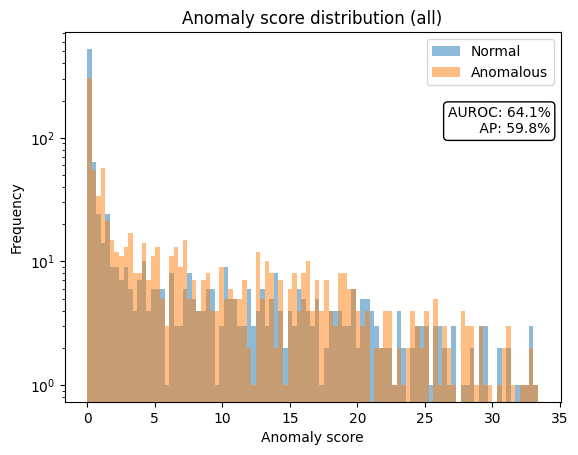

In [10]:
scripts.eval_detector(
    task, 
    detector, 
    save_path=None, 
    pbar=True,
    batch_size=64,
)

TODO:ok, hopefully this is just b/c of the different metric (logit difference between answers and "wrong" answers, should just try sum logits and sum probs)